This notebook solves a 2D elasticity problem using legacy FEniCS. The first foundamental object in FEniCS as then one can declare Finite Element spaces defined on it and associated variational formulations.

In [9]:
from dolfin import *

L = 25.
H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")


The librairy UFL can be used to create custom expression and differential operators. One example is the symmetrized gradient

In [10]:
def eps(v):
    return sym(grad(v))

Next we define the physical properties and constitutive equations

In [11]:
E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

We can define the variational problem to be solved in few lines as follows

In [12]:
rho_g = 1e-3
f = Constant((0, -rho_g))

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx


We want to fix the left side of the domain. This is done via

In [13]:
def left(x, on_boundary):
    return near(x[0], 0.)

bc = DirichletBC(V, Constant((0.,0.)), left)


The problem is solved via 

Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


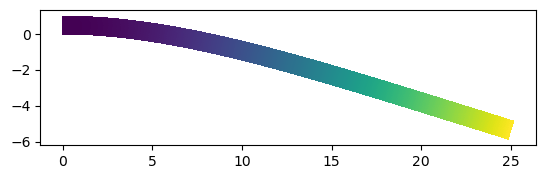

In [14]:
u = Function(V, name="Displacement")
solve(a == l, u, bc)

plot(1e3*u, mode="displacement")

Nothing prevents to extract the matrices in PETSc or scipy sparse format. The maximum deflection si then easily obtained via

In [15]:
print("Maximal deflection:", -u(L,H/2.)[1])
print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))

Maximal deflection: 0.0058637539436155114
Beam theory deflection: 0.005859375


To plot the stresses we save them in a DG space

In [17]:
Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
sig = Function(Vsig, name="Stress")
sig.assign(project(sigma(u), Vsig))
print("Stress at (0,H):", sig(0, H))

Stress at (0,H): [ 1.72741344 -0.22361951 -0.22361951  0.40196756]


The results are then saved in XDMF format

In [18]:
from pathlib import Path
folder_results = Path("results")
folder_results.mkdir(exist_ok=True, parents=True)
filename = folder_results / "elasticity_results.xdmf"
file_results = XDMFFile(str(filename))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(sig, 0.)